In [7]:
import pandas as pd
df = pd.read_csv('/Users/noaluthi/Desktop/Lime_Experiment_data/labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [10]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

texts = [t.lower() for t in df['review'].values]
y = df['sentiment'].values

# 1) Compute word frequencies
all_tokens = [token for t in texts for token in t.split()] 
frequencies = defaultdict(int)
for w in all_tokens:
    frequencies[w] += 1
print('Vocabulary size before rare words tagging:', len(set(all_tokens)))

# 2) Replace words occuring less than 10 times in the corpus with an 
# out-of-vocabulary tag 
texts = [' '.join([w if frequencies[w] > 10 else '' 
                   for w in t.split()])
         for t in texts]
print('Vocabulary size after rare words tagging:', 
      len(set([token for t in texts for token in t.split()])))

# 3) Split train and test sets (should be done before rare words 
# tagging in real world applications)
texts_train, texts_test, y_train, y_test = \
    train_test_split(texts, y, random_state=42)

Vocabulary size before rare words tagging: 257663
Vocabulary size after rare words tagging: 25340


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

vectorizer = TfidfVectorizer()
classifier = RandomForestClassifier(n_estimators=100, max_depth=10)

pipeline = make_pipeline(vectorizer, classifier)

pipeline.fit(texts_train, y_train)
y_preds = pipeline.predict(texts_test)

print('Accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))
print('F1-score: {:.2f} %'.format(100*metrics.f1_score(y_preds, y_test)))

Accuracy: 82.40 %
F1-score: 83.04 %


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


NameError: name 'plt' is not defined

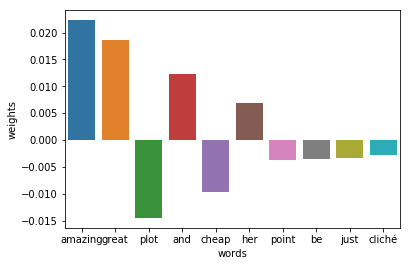

In [17]:
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer
import seaborn as sns
%matplotlib inline

# We choose a sample from test set
idx = 1
text_sample = texts_test[idx]
class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));